In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

/home/bigdata/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = '/data/luodan_data/img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=178 # Shapes of input image
BATCH_SIZE=32 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

tf.reset_default_graph()

z_dim = 100
image_size=64
batch_size=64
sample_size=64
owres=8
gf_dim=64
df_dim=64
gfc_dim=1024
dfc_dim=1024
c_dim=3
lam=0.1

image_shape = [image_size, image_size, c_dim]
d_bns = [batch_norm(name='d_bn{}'.format(i,)) for i in range(4)]

log_size = int(math.log(image_size) / math.log(2))
g_bns = [ batch_norm(name='g_bn{}'.format(i,)) for i in range(log_size)]

In [3]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [4]:
epsilon=1e-5
momentum = 0.9
def batch_norms(x, train, name):
    #print(x)
    return tf.contrib.layers.batch_norm(x, decay=momentum, updates_collections=None, epsilon=epsilon,
                                            center=True, scale=True, is_training=train, scope=name)


def generator(z, is_training):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE  ) as scope:
        z_, h0_w, h0_b = linear(z, gf_dim*8*4*4, 'g_h0_lin', with_w=True)

        hs = [None]
        hs[0] = tf.reshape(z_, [-1, 4, 4, gf_dim * 8])
        hs[0] = tf.nn.relu(g_bns[0](hs[0], is_training))

        i = 1 # Iteration number.
        depth_mul = 8  # Depth decreases as spatial component increases.
        size = 8  # Size increases as depth decreases.

        while size < image_size:
            hs.append(None)
            name = 'g_h{}'.format(i)
            hs[i], _, _ = deconv2d(hs[i-1],
                [batch_size, size, size, gf_dim*depth_mul], name=name, with_w=True)
            hs[i] = tf.nn.relu(g_bns[i](hs[i], is_training))

            i += 1
            depth_mul //= 2
            size *= 2

        hs.append(None)
        name = 'g_h{}'.format(i)
        hs[i], _, _ = deconv2d(hs[i - 1],
            [batch_size, size, size, 3], name=name, with_w=True)

        return tf.nn.tanh(hs[i])

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [7]:
def discriminator(image, is_training, batch_norms=None):
    """
        Your code goes here.
    """
    with tf.variable_scope("discriminator") as scope:
        h0 = lrelu(conv2d(image, df_dim, name='d_h0_conv'))
        h1 = lrelu(d_bns[0](conv2d(h0, df_dim*2, name='d_h1_conv'), is_training))
        h2 = lrelu(d_bns[1](conv2d(h1, df_dim*4, name='d_h2_conv'), is_training))
        h3 = lrelu(d_bns[2](conv2d(h2, df_dim*8, name='d_h3_conv'), is_training))
        h4 = linear(tf.reshape(h3, [-1, 8192]), 1, 'd_h4_lin')
   
    return tf.nn.sigmoid(h4), h4

Now let's define generator and discriminator.

In [15]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')
correct_labels = tf.placeholder(tf.float32, [None, 1], name='correct_labels')
incorrect_labels = tf.placeholder(tf.float32, [None, 1], name='incorrect_labels')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, image_size, image_size, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)
    
    tf.summary.histogram('D_real', D_real)
    tf.summary.histogram('G', G)

    tf.summary.image("input_img_d", (images + 1) * 127.5, max_outputs=4)
    tf.summary.image("fake", (G + 1) * 127.5, max_outputs=4)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [16]:
"""
        You code goes here. Define discriminator and generator losses
"""
d_loss_real = tf.reduce_mean(tf.squared_difference(D_real, 1))

d_loss_fake = tf.reduce_mean(tf.squared_difference(D_fake, 0))

d_loss = 1/2 * (d_loss_real + d_loss_fake)

g_loss = tf.reduce_mean(tf.squared_difference(D_fake, 1))

# d_loss_real =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=correct_labels, logits=D_real_logits), name="d_loss_real")

# d_loss_fake =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=incorrect_labels, logits=D_fake_logits), name="d_loss_fake")

# d_loss = d_loss_real + d_loss_fake

# g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=correct_labels, logits=D_fake_logits), name="g_loss")

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [17]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 



tf.summary.scalar("g_loss", g_loss)
tf.summary.scalar("d_loss", d_loss)
merged = tf.summary.merge_all()

Load data:

In [18]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

Functions for training and evaluations.

In [19]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [20]:
def train(sess, load_dir=None, save_frequency=6000, sample_frequency=7000, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=2, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    writer = tf.summary.FileWriter("tensorbord")
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            #print(batch_images.shape)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
            labels_0 = np.zeros((BATCH_SIZE, 1))
            labels_1 = np.ones((BATCH_SIZE, 1))

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True, correct_labels:labels_1, incorrect_labels:labels_0})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim, feed_dict={z: batch_z, is_training: True, correct_labels:labels_1, incorrect_labels:labels_0})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            if counter % 100 == 0:
                merge = sess.run(merged, feed_dict={z: batch_z, images: batch_images, is_training: False} )
                writer.add_summary(merge, counter)
                writer.flush()
            if counter % 2000 == 0:
                print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                    epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, MERGE_X],os.path.join(sample_dir, 'train_{:02d}_{:04d}.jpg'.format(epoch, idx)))
                print("Sample")

In [21]:
config =  tf.ConfigProto()
config.gpu_options.allow_growth=True
with tf.Session(config=config) as sess:
    train(sess, save_dir='checkpoint')

ValueError: Cannot feed value of shape (32, 178, 178, 3) for Tensor 'D/Placeholder:0', which has shape '(?, 64, 64, 3)'

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

In [21]:
! rm tensorbord/*

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
255


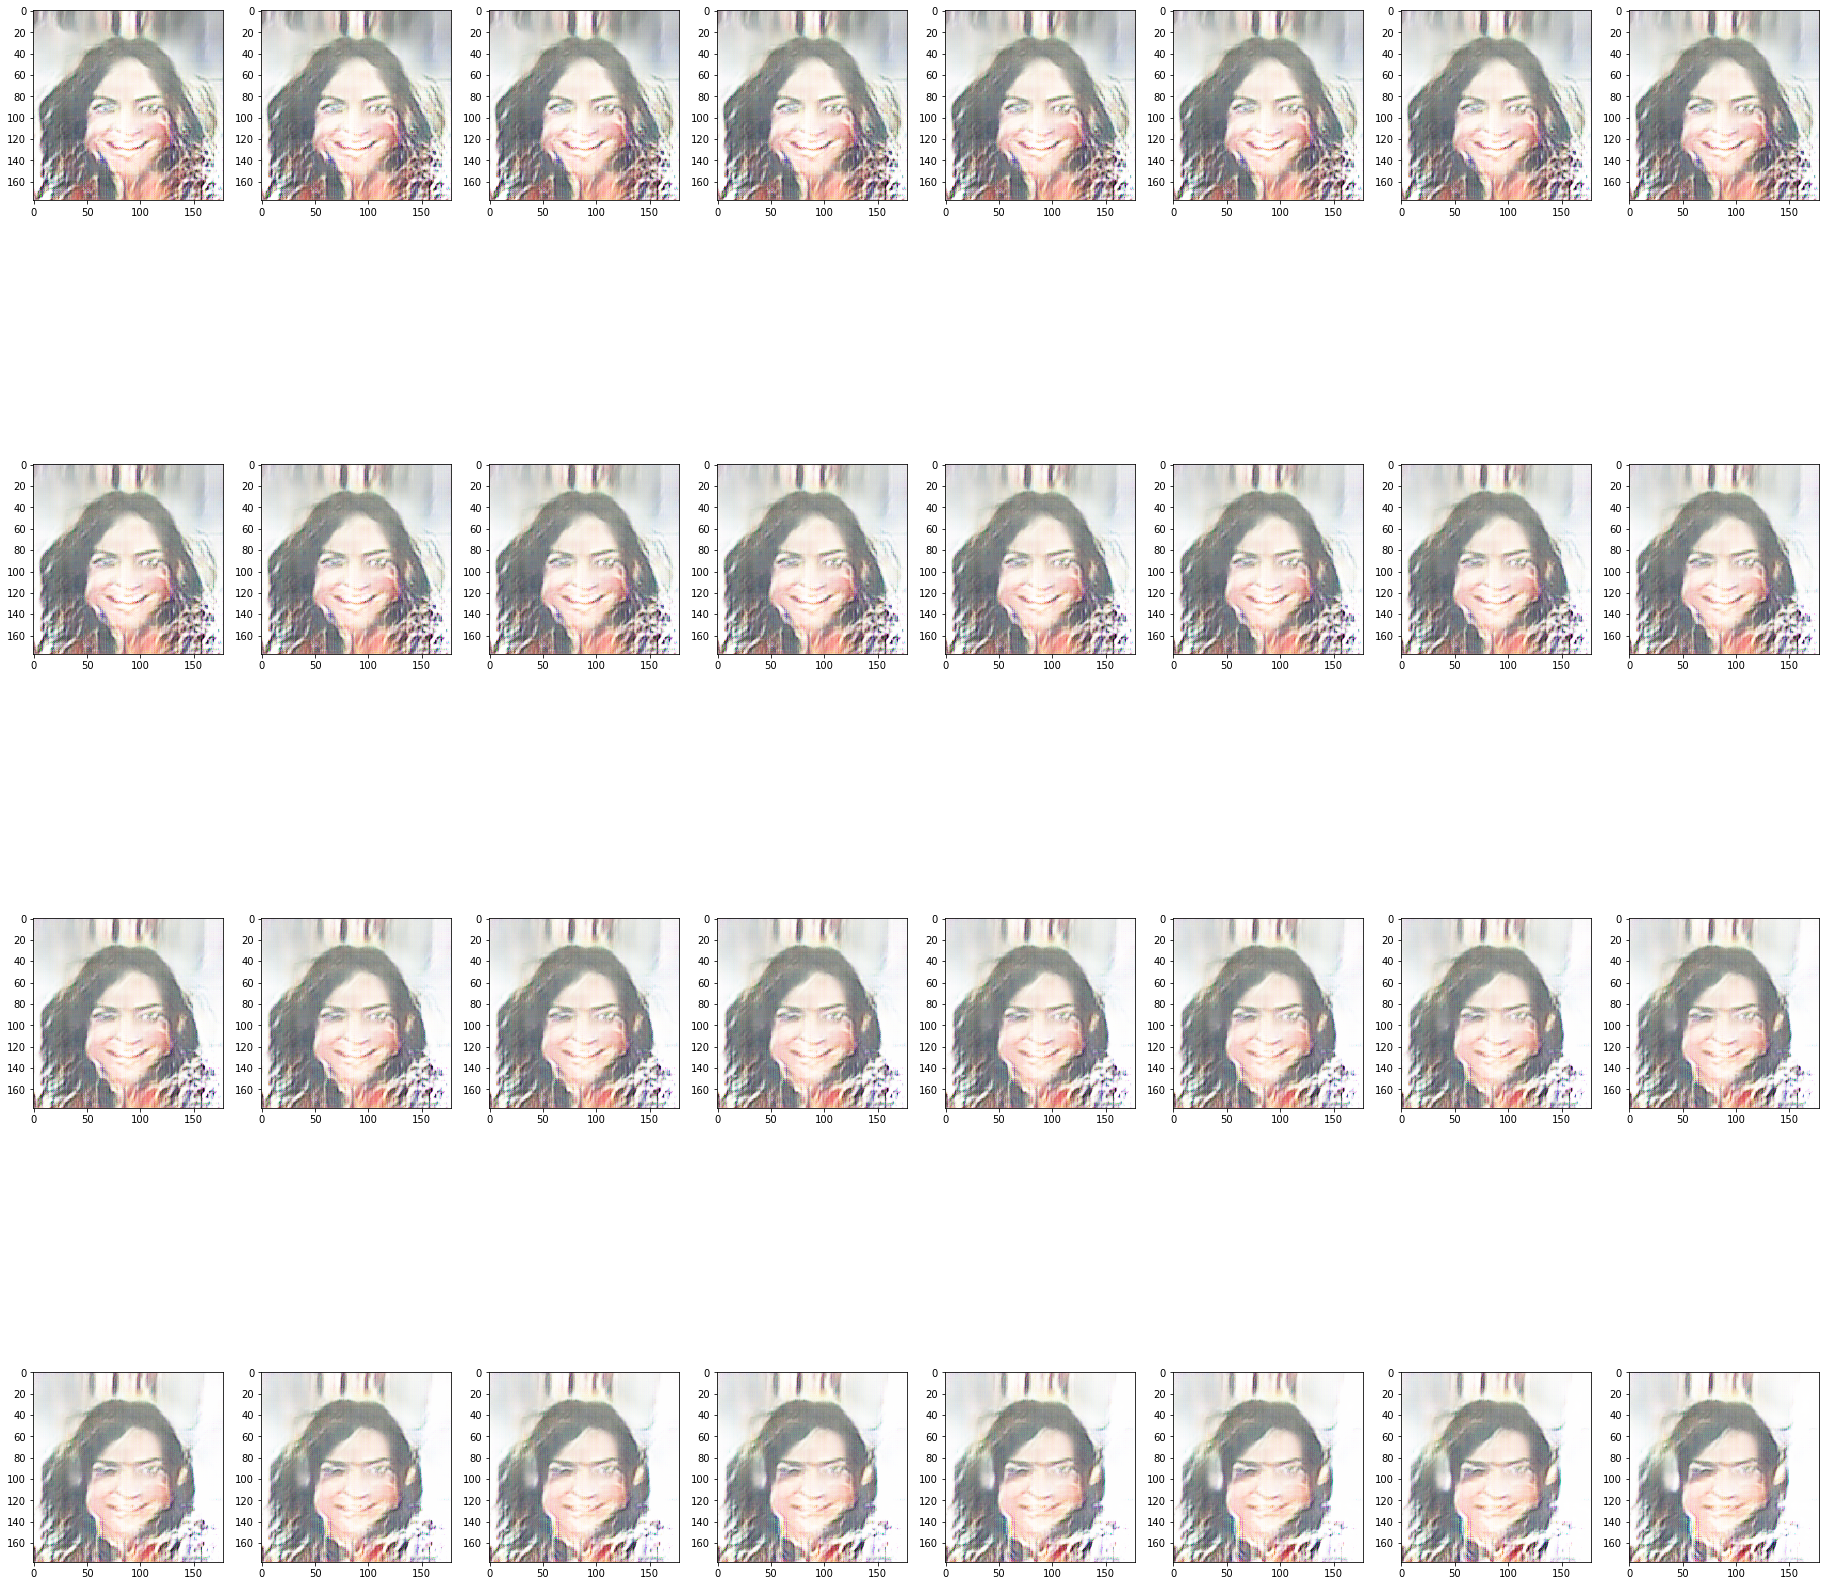

In [36]:
with tf.Session() as sess:
    load(sess, 'checkpoint')
    z1 = np.random.normal(-1,1, Z_DIM)
    z2 = np.random.normal(-1,1, Z_DIM)
    alpha_line = np.linspace(0,1, num=BATCH_SIZE)
    batchz = np.array([alpha * z1 + (1-alpha) * z2 for alpha in alpha_line])
    input_z12 = sess.run(G, feed_dict={z: batchz, is_training: False})
    img12= ((input_z12 + 1)*127.5).astype(np.int32)   
    print(img12.max())
fig=plt.figure(figsize=(32, 32))
columns = 8
rows = 4
for i in range(1, columns*rows+1):
    img = img12[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)  
plt.show()

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

In [28]:
a1 = batchz.mean()

In [32]:
a2 = batchz.mean()
print(a1)
print(a2)

-1.104437062532959
-1.0148769226733967


In [37]:
a3 = batchz.mean()
print(a1)
print(a2)
print(a3)

-1.104437062532959
-1.0148769226733967
-1.0406500088670885


If faces looks really cool, add bonus 1 point to your score.